# Fundementals of Network Science

**Complex Social Systems, 2025** </br>
*Onur Akman, Lab 3, 26/03/2025*

In [1]:
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import scipy

from collections import Counter

random.seed(42)
np.random.seed(42)

# 1) Refresher: Graphs

In [2]:
G = nx.Graph([(1, 2), (2, 3), (3, 4)])
print(f'\
    Edges: {G.edges}, \n\
    Nodes: {G.nodes}, \n\
    Degrees: {G.degree}, \n\
    Connections (as numpy array):\n{nx.to_numpy_array(G)} \
    ')

    Edges: [(1, 2), (2, 3), (3, 4)], 
    Nodes: [1, 2, 3, 4], 
    Degrees: [(1, 1), (2, 2), (3, 2), (4, 1)], 
    Connections (as numpy array):
[[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]]     


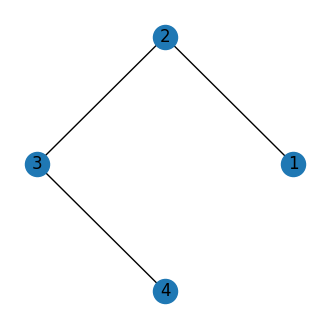

In [3]:
layout = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(4, 4))
nx.draw_networkx(G, pos=layout)
ax.axis("off")
plt.show()
plt.close()

## 1.2) Defining Random Networks

$G_{n, p}$ Model: Each pair of `n` labeled nodes is connected with probability `p`. </br>
In NetworkX, this basic family of random graphs is implemented as `fast_gnp_random_graph`. </br>
Also known as an **Erdős-Rényi** graph or a **binomial graph**.

Average degree: 3.8


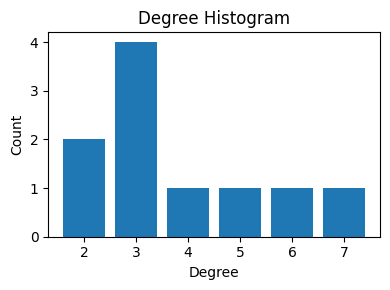

In [4]:
G = nx.fast_gnp_random_graph(10, 0.3, seed=42)
degree_sequence = sorted([d for _, d in G.degree()])
degree_counter = Counter(degree_sequence)
deg, cnt = zip(*degree_counter.items())

print(f"Average degree: {sum(degree_sequence) / len(degree_sequence)}")

fig, ax = plt.subplots(figsize=(4, 3))
plt.bar(deg, cnt)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.tight_layout()
plt.show()
plt.close()

---

### Exercise 1: Random graphs

>In a binomial random graph, investigate how does an average **node degree** changes with increasing: <br>
>    a) number of nodes; <br>
>    b) increasing probability of linkage.

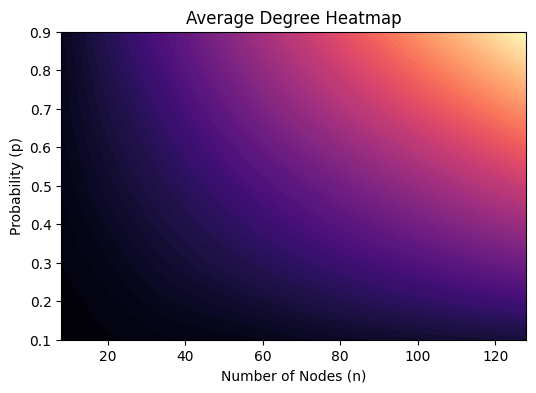

In [ ]:
# --- Data Generation ---

numbers_of_nodes = [8, 16, 32, 64, 128]
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]

avg_degrees = dict() #

for n in numbers_of_nodes:
    for p in probabilities:
        G = nx.fast_gnp_random_graph(n, p, seed=42)
        degree_sequence = [d for _, d in G.degree()]
        degree_counter = Counter(degree_sequence)
        avg_degrees[(n, p)] = sum(degree_sequence) / len(degree_sequence) #
        

# --- Plotting ---

# Flatten the data
points, values = zip(*avg_degrees.items())
points, values = np.array(points), np.array(values)

# Interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(min(numbers_of_nodes), max(numbers_of_nodes), 100),
    np.linspace(min(probabilities), max(probabilities), 100)
)
grid_z = scipy.interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')

plt.figure(figsize=(6, 4))
plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='magma')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Probability (p)')
plt.title('Average Degree Heatmap')

plt.show()
plt.close()


---
# 2) Retrieve networks

In [6]:
facebook_df = pd.read_csv(
    "https://snap.stanford.edu/data/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)

twitter_df = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"]
)

In [7]:
print("--- Facebook data ---\n", facebook_df.sample(5, random_state=42))
print(f"Facebook data shape: {facebook_df.shape}")
print("\n--- Twitter data ---\n", twitter_df.sample(5, random_state=42))
print(f"Twitter data shape: {twitter_df.shape}")

--- Facebook data ---
        start_node  end_node
23139        1188      1366
32340        1496      1630
42613        1958      2645
81545        3204      3280
13436         946      1181
Facebook data shape: (88234, 2)

--- Twitter data ---
          start_node  end_node
1919668   175229187  55705393
2124622   113645326  16025848
842182    217932743  13058232
1488784   193560593  52560743
98983      16003580  29344169
Twitter data shape: (2420766, 2)


**More insights**

In [8]:
facebook_G = nx.from_pandas_edgelist(facebook_df, "start_node", "end_node")
print("-- Facebook Graph --")
print(f"Graph type: {type(facebook_G)}")
print(f"Number of nodes: {facebook_G.number_of_nodes()}")
print(f"Number of edges: {facebook_G.number_of_edges()}")
print(f"Average degree: {sum(dict(facebook_G.degree()).values()) / facebook_G.number_of_nodes()}")

twitter_G = nx.from_pandas_edgelist(twitter_df, "start_node", "end_node")
print("\n-- Twitter Graph --")
print(f"Graph type: {type(twitter_G)}")
print(f"Number of nodes: {twitter_G.number_of_nodes()}")
print(f"Number of edges: {twitter_G.number_of_edges()}")
print(f"Average degree: {sum(dict(twitter_G.degree()).values()) / twitter_G.number_of_nodes()}")


-- Facebook Graph --
Graph type: <class 'networkx.classes.graph.Graph'>
Number of nodes: 4039
Number of edges: 88234
Average degree: 43.69101262688784

-- Twitter Graph --
Graph type: <class 'networkx.classes.graph.Graph'>
Number of nodes: 81306
Number of edges: 1342310
Average degree: 33.018719405701916


In [9]:
def random_walk_sample(G, target_size, seed=42):
    random.seed(seed)
    start_node = random.choice(list(G.nodes))
    visited = {start_node}
    current = start_node
    neighbors = []

    while len(visited) < target_size:
        neighbors = [n for n in  neighbors + list(G.neighbors(current)) if n not in visited]
        neighbors = list(set(neighbors))
        if not neighbors:
            start_node = random.choice(list(G.nodes))
            visited = {start_node}
            current = start_node
            continue
        current = random.choice(neighbors)
        visited.add(current)
    return G.subgraph(visited).copy()

twitter_G = random_walk_sample(twitter_G, facebook_G.number_of_nodes(), seed=42)
print(f"Number of nodes: {twitter_G.number_of_nodes()}")
print(f"Number of edges: {twitter_G.number_of_edges()}")
print(f"Average degree: {sum(dict(twitter_G.degree()).values()) / twitter_G.number_of_nodes()}")

Number of nodes: 4039
Number of edges: 14322
Average degree: 7.091854419410745


**Have a look at our of the networks using spring layout**

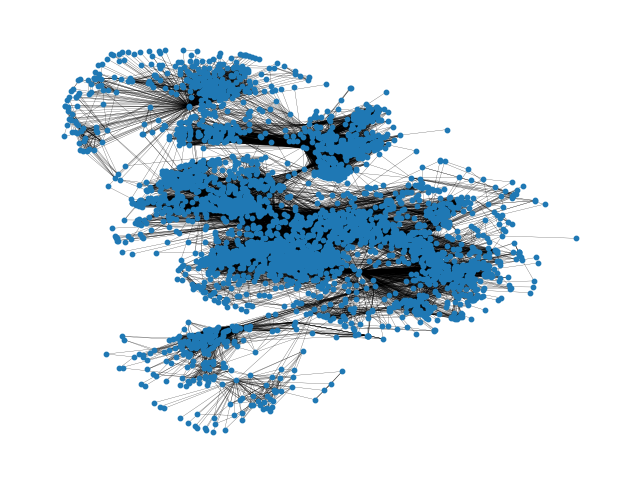

In [ ]:
pos = nx.spring_layout(facebook_G, iterations=17, seed=42)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
nx.draw_networkx(facebook_G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
plt.show()
plt.close()

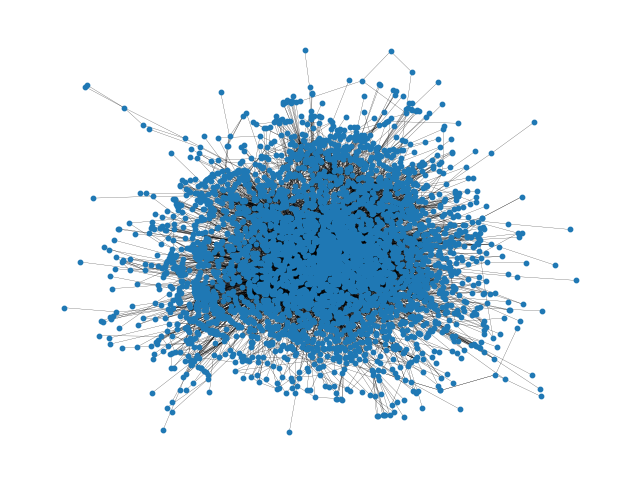

In [11]:
pos = nx.spring_layout(twitter_G, iterations=17, seed=42) # Try also Twitter

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
nx.draw_networkx(twitter_G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
plt.show()
plt.close()

---
### Exercise 2: Six handshakes

<img src="https://people.com/thmb/Q_qTsGov1TBp3lCJr0lI0sxP6VA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(958x681:960x683)/Footloose-Kevin-Bacon-061624-01-20ddcdcf0d8b42f89e9ca908cc63edb1.jpg" align="right" width="20%"/>

There is a famous idea called [**six handshakes rule**](https://en.wikipedia.org/wiki/Six_degrees_of_separation).

**Six degrees of separation** is the idea that all people are six or fewer social connections away from each other. </br>
As a result, a chain of *friend of a friend* statements can connect any two people in a maximum of **six steps**. </br>
It is also known as the **six handshakes rule**.

> Compute the average distance between pairs of nodes in the graph using [NetworkX shortest path functions](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html).

In [12]:
shortest_path_lengths = dict()
for node in facebook_G.nodes:
    lengths = nx.single_source_shortest_path_length(facebook_G, node)
    for target_node in lengths.keys():
        # ---
        if node == target_node:
            continue
        # ---
        shortest_path_lengths[(node, target_node)] = lengths[target_node]
        
mean_length, max_length, min_length = np.mean(list(shortest_path_lengths.values())), max(shortest_path_lengths.values()), min(shortest_path_lengths.values())
print(f"Mean shortest path length: {mean_length}\nMax: {max_length}\nMin: {min_length}")

Mean shortest path length: 3.6925068496963913
Max: 8
Min: 1


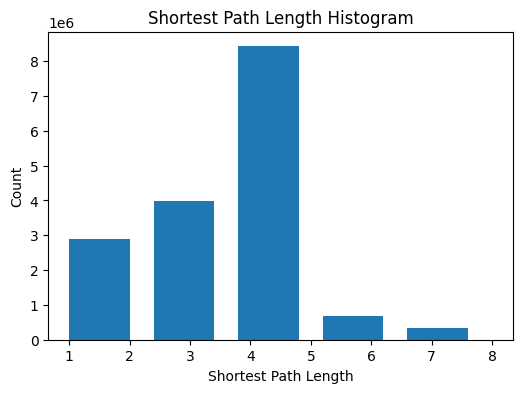

In [13]:
shortest_path_lengths_seq = list(shortest_path_lengths.values())
plt.figure(figsize=(6, 4))
plt.hist(shortest_path_lengths_seq, bins=5, width=1)
plt.xlabel("Shortest Path Length")
plt.ylabel("Count")
plt.title("Shortest Path Length Histogram")
plt.show()
plt.close()

In [14]:
avg_shortest_path_length = nx.average_shortest_path_length(twitter_G)
print(f"Average shortest path length: {avg_shortest_path_length}")

Average shortest path length: 4.46172919532331


---
# 3) Communities

- **Communities** in networks are **groups of nodes** that are more **densely connected** to each other than to the rest of the network. 
- The **Girvan-Newman** algorithm is a method for identifying communities within networks by **iteratively removing edges with high betweenness centrality**.
- By targeting and eliminating these critical connections—often the bridges between clusters—the algorithm gradually reveals the network’s underlying community structure, offering valuable insights into how nodes group together.
- **Betweenness centrality** measures **how often a node appears on the shortest paths between other nodes in the network**. It is calculated as:

$$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}},$$

where $\sigma_{st}$ is the total number of shortest paths from node $s$ to node $t$, and $\sigma_{st}(v)$ is the number of those paths that pass through $v$.

In [15]:
def draw(G, edges_to_highlight, colour_map=None, iter_step=-1, func=nx.shell_layout):
    try:
        layout = func(G, seed=42)
    except:
        layout = func(G)
    fig, ax = plt.subplots(figsize=(6, 6))
    if colour_map is not None:
        nx.draw_networkx(G, node_color=colour_map, pos=layout, node_size=40, with_labels=False, width=0.15)
        nx.draw_networkx_edges(G, pos=layout, edgelist=edges_to_highlight, width=2, edge_color=(1, 0, 0, 1))
    else:
        nx.draw_networkx(G, pos=layout, node_size=40, with_labels=False, width=0.15)
    ax.axis("off")
    if iter_step != -1:
        plt.title(f'Step: {iter_step}')
    plt.show()
    plt.close()

The `karate_club_graph` in NetworkX is a well-known social network representing the interactions among members of a karate club.

<class 'networkx.classes.graph.Graph'>


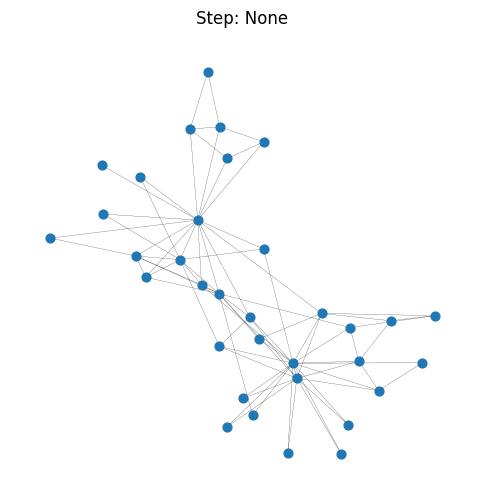

In [16]:
G = nx.karate_club_graph()
print(type(G))
draw(G, [], iter_step=None, func=nx.spring_layout)

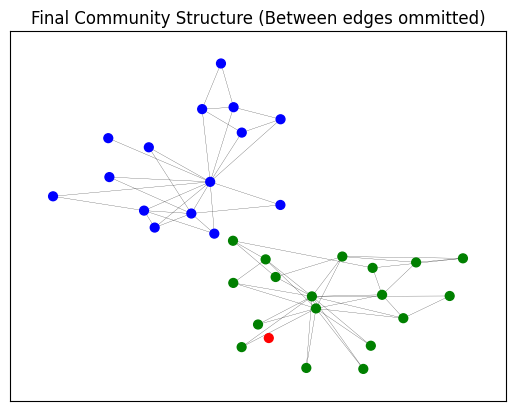

In [17]:
target_communities = 3
num_conn_comp = 1
#draw(G, [], None, 1, func=nx.spring_layout)

# Copy of G for modification
G_temp = G.copy()

# To keep track of removed edges
removed_edges = list()

# Use a consistent layout for all plots
pos = nx.spring_layout(G, seed=42)

# List of distinct colors
base_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

while True:
    
    if num_conn_comp == target_communities:
        break
    
    # 1. Compute edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G_temp)
    
    # 2. Remove the edge with highest betweenness
    edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
    G_temp.remove_edge(*edge_to_remove)
    removed_edges.append(edge_to_remove)
    
    # 3. Find connected components as communities
    communities = list(nx.connected_components(G_temp))
    
    # 4. Map node to community color
    color_map = [''] * G.number_of_nodes()
    for color_index, community in enumerate(communities):
        for node in community:
            color_map[node] = list(mcolors.BASE_COLORS.keys())[color_index % len(mcolors.BASE_COLORS)]
            
    if len(communities) > num_conn_comp:
        #draw(G, removed_edges, color_map, len(communities), func=nx.spring_layout)
        num_conn_comp = len(communities)
        
nx.draw_networkx(G_temp, pos=pos, node_color=color_map, node_size=40, with_labels=False, width=0.15)
plt.title("Final Community Structure (Between edges ommitted)")
plt.show()
plt.close()

---
### Exercise 3: Finding communities using Girvan Newman

NetworkX provides an implementation of the Girvan Newman method. </br>
> Use NetworkX's `nx.community.girvan_newman` method (find [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)) to regenerate the communities we found above.

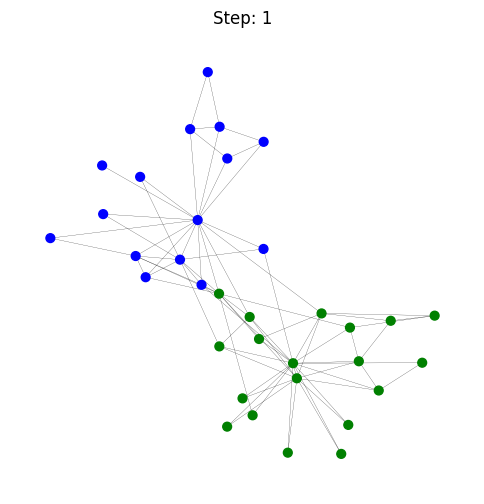

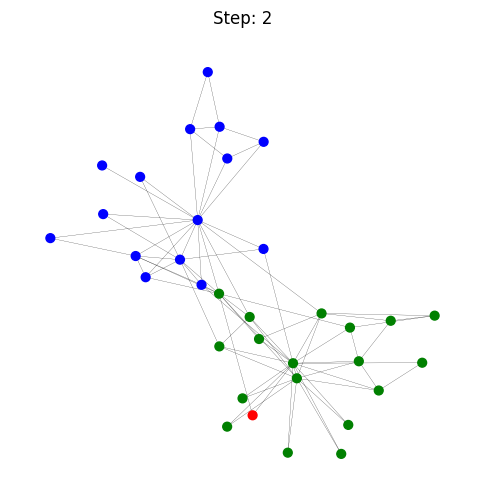

In [18]:
community_generator = nx.community.girvan_newman(G)

for step, communities in enumerate(itertools.islice(community_generator, target_communities-1)):

    # Assign a color to each node based on its community
    color_map = [''] * G.number_of_nodes()
    for color_index, community in enumerate(communities):
        for node in community:
            color_map[node] = list(mcolors.BASE_COLORS.keys())[color_index % len(mcolors.BASE_COLORS)]

    # Visualize the current step
    draw(G, [], color_map, step+1, func=nx.spring_layout)

---
### Exercise 4: Impact of number of communities

> Using **Girvan-Newman method**, create loop where you measure the **diameter and an average distance within communites** in a **facebook_G subgraph** (100 nodes) for increasing number of communities (up to $10^{th}$ step).

**Hint:** The diameter of a graph is the length of the shortest path between the most distanced nodes (see `nx.diameter`).

Step 1: 2 communities | Mean Diameter = 5.000 | Mean distance = 2.309
Step 2: 3 communities | Mean Diameter = 4.333 | Mean distance = 2.058
Step 3: 4 communities | Mean Diameter = 3.500 | Mean distance = 1.772
Step 4: 5 communities | Mean Diameter = 2.800 | Mean distance = 1.413
Step 5: 6 communities | Mean Diameter = 2.333 | Mean distance = 1.170
Step 6: 7 communities | Mean Diameter = 2.286 | Mean distance = 1.165
Step 7: 8 communities | Mean Diameter = 2.000 | Mean distance = 1.147
Step 8: 9 communities | Mean Diameter = 1.778 | Mean distance = 1.018
Step 9: 10 communities | Mean Diameter = 1.600 | Mean distance = 0.916
Step 10: 11 communities | Mean Diameter = 1.455 | Mean distance = 0.830


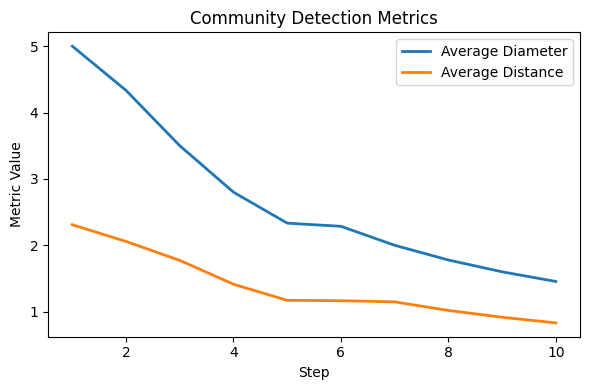

In [19]:
G = random_walk_sample(facebook_G, 100, seed=42)

communities_generator = nx.community.girvan_newman(G)
num_communities = list(range(1, 11))
mean_diameters, mean_distances = list(), list()

# Loop for the first 10 steps of community detection
for step in num_communities:
    communities = next(communities_generator)
    diameters, avg_dists = list(), list()
    
    # Calculate metrics for each community
    for community in communities:
        subG = G.subgraph(community)
        diameters.append(nx.diameter(subG))
        avg_dists.append(nx.average_shortest_path_length(subG))
        
    mean_diameters.append(sum(diameters) / len(diameters))
    mean_distances.append(sum(avg_dists) / len(avg_dists))
    
    print(f"Step {step}: {len(communities)} communities | Mean Diameter = {mean_diameters[-1]:.3f} | Mean distance = {mean_distances[-1]:.3f}")
    
# Plot the metrics
plt.figure(figsize=(6, 4))
plt.plot(num_communities, mean_diameters, label="Average Diameter", linewidth=2)
plt.plot(num_communities, mean_distances, label="Average Distance", linewidth=2)

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.title("Community Detection Metrics")

plt.legend()
plt.tight_layout()
plt.show()
plt.close()

---

# 4) Centralities: PageRank

- PageRank centrality is based on Google's algorithm used to evaluate the importance or relevance of nodes in a network. (See [here](https://en.wikipedia.org/wiki/PageRank))
- It assigns **a score to each node** based on the **number and quality of links (or edges) pointing to it**. 
- It is used to rank web pages in search engines, but it can also be applied to other types of networks to identify key players or important nodes.
- It is defined by the **recursive** formula:

$$
PR(i) = \frac{1-d}{N} + d \sum_{j \in M(i)} \frac{PR(j)}{L(j)},
$$

- where:
    - $PR(i)$ is the PageRank of node $i$, 
    - $d$ is the damping factor (typically set to 0.85), 
    - $N$ is the total number of nodes, 
    - $M(i)$ is the set of nodes linking to $i$, and 
    - $L(j)$ is the number of outbound links from node $j$.
- Breaking it down:
    - $\frac{1-d}{N}$ assigns a baseline score to every node, 
    - The damping factor $d$ represents the probability that **a random surfer continues following links rather than jumping to a random node**,
    - The sum $\sum_{j \in M(i)} \frac{PR(j)}{L(j)}$ aggregates the contribution of each node $j$ that points to node $i$.
- Intuition:
    - This formulation captures that **a node’s importance depends not just on the number of incoming links, but on the quality of those links**.
    - A node gains more importance if it is **linked by other important nodes that do not spread their influence** too thinly among many targets.

<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/PageRanks-Example.svg/1920px-PageRanks-Example.svg.png" alt="Source: https://en.wikipedia.org/wiki/PageRank" width="400" />
</div>

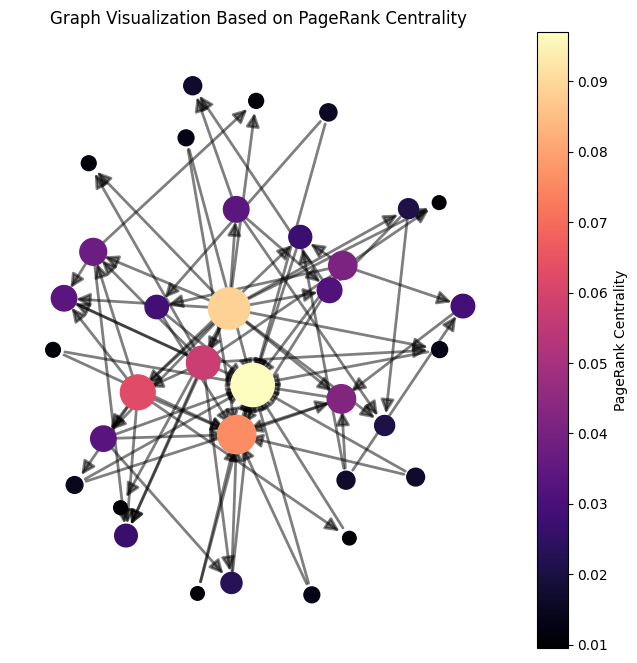

In [20]:
G = nx.karate_club_graph()

pagerank = nx.pagerank(G, alpha=0.85)

pos = nx.spring_layout(G, seed=42, k=2)


node_sizes = [10000 * pagerank[node] for node in G.nodes()]
node_colors = [pagerank[node] for node in G.nodes()]


plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                               node_color=node_colors, cmap=plt.cm.magma)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=True, width=2, arrowsize=20, arrowstyle='-|>')
plt.colorbar(nodes, label='PageRank Centrality')

plt.title("Graph Visualization Based on PageRank Centrality")
plt.axis('off')
plt.show()

---
### Exercise 5: Impact of number of the damping factor

*The damping factor is a parameter that represents the probability that a user will follow a link on a page rather than randomly jumping to any other page.*

> Investigate the influence of the damping factor in social media networks. With decreasingly probability of random jumps, what kind of changes do we see in PageRank centralities?

In [21]:
# Start by recreating our graphs, this time as ! directed graphs !

facebook_G = nx.from_pandas_edgelist(facebook_df, "start_node", "end_node", create_using=nx.DiGraph())
twitter_G = nx.from_pandas_edgelist(twitter_df, "start_node", "end_node", create_using=nx.DiGraph())
#twitter_G = random_walk_sample(twitter_G, facebook_G.number_of_nodes(), seed=42)

In [ ]:
damping_factors = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
fb_maxes, tw_maxes = list(), list() #
fb_means, tw_means = list(), list() #

for damp_factor in damping_factors:
    print(f"\n--- Damping factor: {damp_factor} ---")
    pagerank_fb = nx.pagerank(facebook_G, alpha=damp_factor)
    mean_pr_fb = sum(pagerank_fb.values()) / len(pagerank_fb)
    max_pr_fb, max_pr_user_fb = max(pagerank_fb.values()), max(pagerank_fb, key=pagerank_fb.get)
    fb_means.append(mean_pr_fb) #
    fb_maxes.append(max_pr_fb) #
    print(f"Facebook PageRank: Mean = {mean_pr_fb:.5f} | Max = {max_pr_fb:.5f} | User = {max_pr_user_fb}")

    pagerank_tw = nx.pagerank(twitter_G, alpha=damp_factor)
    mean_pr_tw = sum(pagerank_tw.values()) / len(pagerank_tw)
    max_pr_tw, max_pr_user_tw = max(pagerank_tw.values()), max(pagerank_tw, key=pagerank_tw.get)
    tw_means.append(mean_pr_tw) #
    tw_maxes.append(max_pr_tw) #
    print(f"Twitter PageRank: Mean = {mean_pr_tw:.5f} | Max = {max_pr_tw:.5f} | User = {max_pr_user_tw}")


--- Damping factor: 0.05 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00040 | User = 1888
Twitter PageRank: Mean = 0.00001 | Max = 0.00020 | User = 115485051

--- Damping factor: 0.15 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00077 | User = 1888
Twitter PageRank: Mean = 0.00001 | Max = 0.00056 | User = 115485051

--- Damping factor: 0.25 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00122 | User = 1888
Twitter PageRank: Mean = 0.00001 | Max = 0.00091 | User = 115485051

--- Damping factor: 0.35 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00179 | User = 3434
Twitter PageRank: Mean = 0.00001 | Max = 0.00123 | User = 115485051

--- Damping factor: 0.45 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00269 | User = 3434
Twitter PageRank: Mean = 0.00001 | Max = 0.00153 | User = 115485051

--- Damping factor: 0.55 ---
Facebook PageRank: Mean = 0.00025 | Max = 0.00389 | User = 3434
Twitter PageRank: Mean = 0.00001 | Max = 0.00244 | User = 115485051

--- Damping factor: 0.65 --

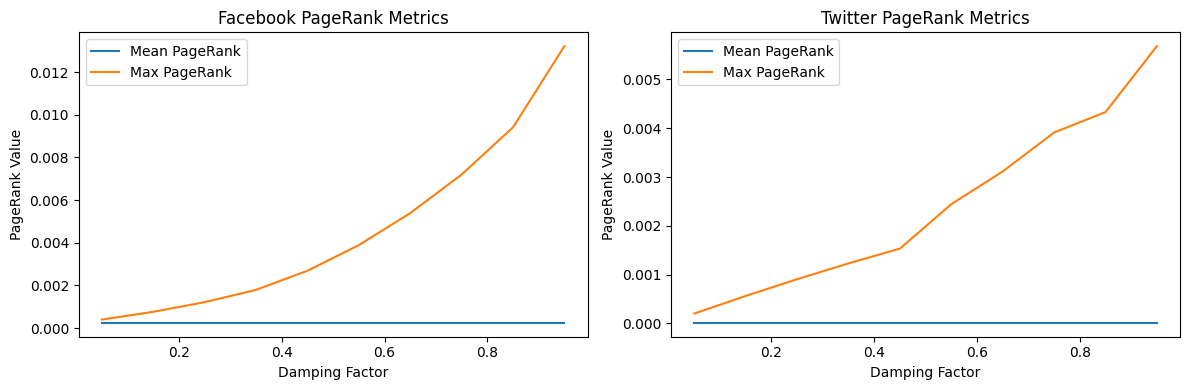

In [23]:
# 2 plots, one for each dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
axs = ax.flatten()

# Facebook
axs[0].plot(damping_factors, fb_means, label="Mean PageRank")
axs[0].plot(damping_factors, fb_maxes, label="Max PageRank")
axs[0].set_xlabel("Damping Factor")
axs[0].set_ylabel("PageRank Value")
axs[0].set_title("Facebook PageRank Metrics")
axs[0].legend()

# Twitter
axs[1].plot(damping_factors, tw_means, label="Mean PageRank")
axs[1].plot(damping_factors, tw_maxes, label="Max PageRank")
axs[1].set_xlabel("Damping Factor")    
axs[1].set_ylabel("PageRank Value")
axs[1].set_title("Twitter PageRank Metrics")
axs[1].legend()

plt.tight_layout()
plt.show()
plt.close()

---
### Exercise 6: Network communities and local hubs

> Examine how the PageRank centralities evolve within the community subgraphs of a Twitter network as the number of communities increases. (up to 4 iterations)

In [24]:
community_generator = nx.community.girvan_newman(random_walk_sample(twitter_G, 200, seed=42))

for step, communities in enumerate(itertools.islice(community_generator, 4)):
    print(f"\nStep {step+1}: {len(communities)} communities")
    mean_top_pageranks = list()
    for community in communities:
        comm_G = twitter_G.subgraph(community)
        pagerank = nx.pagerank(comm_G)
        print(f"Community ({len(pagerank)} nodes) PageRank: Mean = {sum(pagerank.values()) / len(pagerank):.5f} | Max = {max(pagerank.values()):.5f}")
        mean_top_pageranks.append(max(pagerank.values()))
    print(f"Mean of top pageranks: {sum(mean_top_pageranks) / len(mean_top_pageranks):.5f}")


Step 1: 2 communities
Community (140 nodes) PageRank: Mean = 0.00714 | Max = 0.03319
Community (60 nodes) PageRank: Mean = 0.01667 | Max = 0.06433
Mean of top pageranks: 0.04876

Step 2: 3 communities
Community (96 nodes) PageRank: Mean = 0.01042 | Max = 0.05331
Community (44 nodes) PageRank: Mean = 0.02273 | Max = 0.09638
Community (60 nodes) PageRank: Mean = 0.01667 | Max = 0.06433
Mean of top pageranks: 0.07134

Step 3: 4 communities
Community (96 nodes) PageRank: Mean = 0.01042 | Max = 0.05331
Community (44 nodes) PageRank: Mean = 0.02273 | Max = 0.09638
Community (23 nodes) PageRank: Mean = 0.04348 | Max = 0.08782
Community (37 nodes) PageRank: Mean = 0.02703 | Max = 0.11845
Mean of top pageranks: 0.08899

Step 4: 5 communities
Community (89 nodes) PageRank: Mean = 0.01124 | Max = 0.05847
Community (7 nodes) PageRank: Mean = 0.14286 | Max = 0.25026
Community (44 nodes) PageRank: Mean = 0.02273 | Max = 0.09638
Community (23 nodes) PageRank: Mean = 0.04348 | Max = 0.08782
Community